<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Part-1" data-toc-modified-id="Part-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Part 1</a></span><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Aim" data-toc-modified-id="Aim-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Aim</a></span></li><li><span><a href="#Gender-identity" data-toc-modified-id="Gender-identity-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Gender identity</a></span></li><li><span><a href="#Main-language" data-toc-modified-id="Main-language-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Main language</a></span></li></ul></li><li><span><a href="#Part-2" data-toc-modified-id="Part-2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Part 2</a></span><ul class="toc-item"><li><span><a href="#Region" data-toc-modified-id="Region-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Region</a></span></li><li><span><a href="#Urban-rural" data-toc-modified-id="Urban-rural-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Urban-rural</a></span></li><li><span><a href="#Bokeh-trial-visualisation" data-toc-modified-id="Bokeh-trial-visualisation-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Bokeh trial visualisation</a></span></li></ul></li><li><span><a href="#Outputs" data-toc-modified-id="Outputs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Outputs</a></span></li></ul></div>

# Part 1

## Import libraries

In [1]:
# used to manipulate dataframes
import pandas as pd

# used to create visualisations
import seaborn as sns
import matplotlib.pylab as plt

# used to create interactive visualisations
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

# used to apply scatterplot labels at selective distances 
from sklearn.neighbors import NearestNeighbors

# used to clean column names
from janitor import *

# used to calculate correlation
from scipy.stats import pearsonr

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Aim

To eventually create some interactive scatterplots which explore the relationship between:

* relationship between non-response (for gender identity Q) and the % of Non-English speakers in our LA's
* relationship between religious group % and contribution to non-response rates in LAs

In this notebook, we'll just be focusing on the first bullet point. 

Let's get started.

## Gender identity

### Read-in gender identity data

First we will import the gender identity dataset which details GI responses by local authority.

We are importing cleaned data - column names have been shorted and underscored where necessary. 


In [2]:
df = pd.read_csv('/Users/loucap/Documents/GitWork/InteractiveGender/Data/gi_renamed.csv')

### Overview

In [3]:
# Let's check it out..

df.head()

,LA_code,LA_name,GI_code,GI_categories,Observation
0,E06000001,Hartlepool,-8,Does not apply,0
1,E06000001,Hartlepool,1,Gender identity the same as sex registered at ...,70588
2,E06000001,Hartlepool,2,Gender identity different from sex registered ...,167
3,E06000001,Hartlepool,3,Trans woman,49
4,E06000001,Hartlepool,4,Trans man,51


In [4]:
# Some more info...

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2317 entries, 0 to 2316
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LA_code        2317 non-null   object
 1   LA_name        2317 non-null   object
 2   GI_code        2317 non-null   int64 
 3   GI_categories  2317 non-null   object
 4   Observation    2317 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 90.6+ KB


In [5]:
# Let's look at our GI codes

df.GI_code.unique()

array([-8,  1,  2,  3,  4,  5,  6])

In [6]:
# Let's see what the GI codes refer to...

df.GI_categories.unique()

array(['Does not apply',
       'Gender identity the same as sex registered at birth',
       'Gender identity different from sex registered at birth but no specific identity given',
       'Trans woman', 'Trans man', 'All other gender identities',
       'Not answered'], dtype=object)

In [7]:
# We are working with 331 local authorities

df.LA_name.nunique()

331

In [8]:
# You can see that we have our counts for each category for a specific local authority

df.head(10)

,LA_code,LA_name,GI_code,GI_categories,Observation
0,E06000001,Hartlepool,-8,Does not apply,0
1,E06000001,Hartlepool,1,Gender identity the same as sex registered at ...,70588
2,E06000001,Hartlepool,2,Gender identity different from sex registered ...,167
3,E06000001,Hartlepool,3,Trans woman,49
4,E06000001,Hartlepool,4,Trans man,51
5,E06000001,Hartlepool,5,All other gender identities,54
6,E06000001,Hartlepool,6,Not answered,3777
7,E06000002,Middlesbrough,-8,Does not apply,0
8,E06000002,Middlesbrough,1,Gender identity the same as sex registered at ...,106009
9,E06000002,Middlesbrough,2,Gender identity different from sex registered ...,496


### Data pre-processing

Calculating GI response percentages.

In [9]:
# Let's calculate the GI_category percentages for each local authority, then subset our df
# I've named this new column NR_rate

df['NR_rate'] = ''


for i in df.LA_code.unique():
    b = df[df.LA_code == i]
    percent = (b['Observation'] / b['Observation'].sum() * 100).round(2)
    df.loc[b.index, 'NR_rate'] = percent
    
    
# Now let's subset our df so that we're just left with our Non-response rates
df = df[df['GI_code'] == 6].drop(columns=['LA_code', 'GI_code', 'Observation', 'GI_categories'])

    
# Sort df alphabetically by LA_name and reset index 

df = df.sort_values(by = 'LA_name').reset_index(drop = True)

In [10]:
# Sweet. Now we have our NR_rate for each LA!

df

,LA_name,NR_rate
0,Adur,4.68
1,Allerdale,4.61
2,Amber Valley,5.44
3,Arun,5.44
4,Ashfield,5.64
...,...,...
326,Wrexham,6.99
327,Wychavon,4.84
328,Wyre,4.61
329,Wyre Forest,5.62


## Main language

Okay, so we have our non-response rate for each LA, we also need the % of Non-English speakers.

Let's start by importing the main language dataset, which classifies residents by their main language.

### Read-in data

In [11]:
lang = pd.read_csv('/Users/loucap/Documents/GitWork/InteractiveGender/Data/Language_2021.csv')

In [12]:
lang.head()

,Lower Tier Local Authorities Code,Lower Tier Local Authorities,Main language (detailed) (95 categories) Code,Main language (detailed) (95 categories),Observation
0,E06000001,Hartlepool,-8,Does not apply,2918
1,E06000001,Hartlepool,1,English (English or Welsh in Wales),87544
2,E06000001,Hartlepool,2,Welsh or Cymraeg (in England only),4
3,E06000001,Hartlepool,3,Other UK language: Gaelic (Irish),0
4,E06000001,Hartlepool,4,Other UK language: Gaelic (Scottish),0


### Cleaning dataset

Unlike our gender identity dataset, this one hasn't been cleaned before hand. So let's spruce it up a bit.

In [13]:

lang.rename(columns={'Lower Tier Local Authorities Code':'LA_code', 'Lower Tier Local Authorities':'LA_name', 'Main language (detailed) (95 categories) Code': 'ML_code', 'Main language (detailed) (95 categories)': 'ML_categories'}, inplace=True)

In [14]:
# Nice. 

lang.head()

,LA_code,LA_name,ML_code,ML_categories,Observation
0,E06000001,Hartlepool,-8,Does not apply,2918
1,E06000001,Hartlepool,1,English (English or Welsh in Wales),87544
2,E06000001,Hartlepool,2,Welsh or Cymraeg (in England only),4
3,E06000001,Hartlepool,3,Other UK language: Gaelic (Irish),0
4,E06000001,Hartlepool,4,Other UK language: Gaelic (Scottish),0


### Pre-processing 

Calculating Non-English LA percentages

In [15]:
# First, let's remove our 'Does not apply' response category 

lang = lang[lang['ML_code'] != -8]


In [16]:
# Let's create a dataset of just non-english languages

non_eng = lang[lang['ML_code'] != 1]

In [17]:
non_eng.head()

,LA_code,LA_name,ML_code,ML_categories,Observation
2,E06000001,Hartlepool,2,Welsh or Cymraeg (in England only),4
3,E06000001,Hartlepool,3,Other UK language: Gaelic (Irish),0
4,E06000001,Hartlepool,4,Other UK language: Gaelic (Scottish),0
5,E06000001,Hartlepool,5,Other UK language: Manx Gaelic,0
6,E06000001,Hartlepool,6,Other UK language: Gaelic (Not otherwise speci...,0


In [18]:
# Calculate the sum of 'Observation' for each 'LA_name' in both non_eng and lang dataframes

# Create new df containing non_eng summed LA observations and do same for lang

non_eng_sum = non_eng.groupby('LA_name')['Observation'].sum().reset_index()

lang_sum = lang.groupby('LA_name')['Observation'].sum().reset_index()

# Perform calculation and append results to new column 'Percentages'

non_eng_sum['Non_Eng_Percentages'] = (non_eng_sum['Observation'] /lang_sum['Observation'] * 100).round(2)



In [19]:
# Neat. We now have our % of non-eng speakers for each LA!

non_eng_sum.head()

,LA_name,Observation,Non_Eng_Percentages
0,Adur,1971,3.14
1,Allerdale,1073,1.15
2,Amber Valley,1850,1.51
3,Arun,9469,5.89
4,Ashfield,3944,3.22


#### Merge datasets

In [20]:
# Merge non_eng_sum df and df together

merged_df = non_eng_sum.merge(df, on = ['LA_name'])

merged_df.head()

,LA_name,Observation,Non_Eng_Percentages,NR_rate
0,Adur,1971,3.14,4.68
1,Allerdale,1073,1.15,4.61
2,Amber Valley,1850,1.51,5.44
3,Arun,9469,5.89,5.44
4,Ashfield,3944,3.22,5.64


### Data processing

Awesome. Now we can move on to our data processing, where we can extract some useful information and insights from our 2 variables. We're going to make a simple scatterplot showing the relationship between non-response rate and % of non-english speakers in our LAs.

#### Scatterplot visualisation

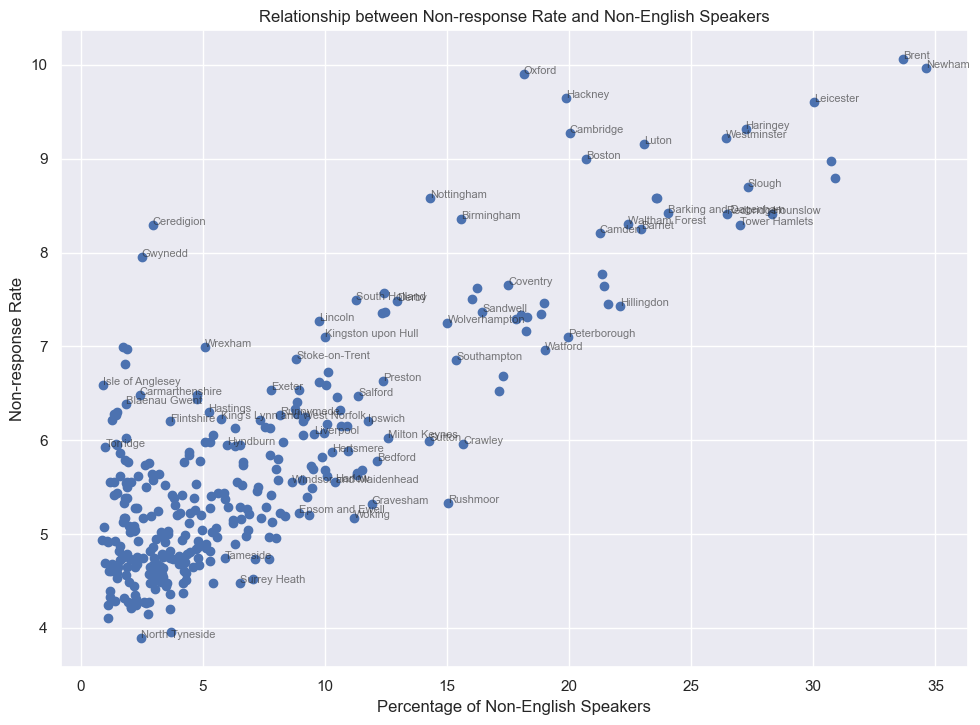

In [21]:
import matplotlib.pyplot as plt

# Set the size of the seaborn plot

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Now we can visualise the relationship between GI NR and % of Non-Eng speakers

plt.scatter(merged_df['Non_Eng_Percentages'], merged_df['NR_rate'])

# We can use a bit of Machine Learning to selectively apply LA labels

# Find nearest neighbors
X = merged_df[['Non_Eng_Percentages', 'NR_rate']].values
nbrs = NearestNeighbors(n_neighbors=2).fit(X)
distances, indices = nbrs.kneighbors(X)
min_distance = 0.3

for i, row in merged_df.iterrows():
    if distances[i][1] >= min_distance:
        plt.annotate(row['LA_name'], (row['Non_Eng_Percentages'], row['NR_rate']), fontsize=8, alpha=0.6)

plt.xlabel('Percentage of Non-English Speakers')
plt.ylabel('Non-response Rate')
plt.title('Relationship between Non-response Rate and Non-English Speakers')
plt.show()

### Correlation

In [22]:
# Calculate the Pearson correlation coefficient and the p-value

correlation, p_value = pearsonr(merged_df['Non_Eng_Percentages'], df['NR_rate'])

print("Correlation:", correlation)
print("P-value:", p_value)

Correlation: 0.8262132604921236
P-value: 5.410893322696366e-84


# Part 2

Okay, so that's all well and good, but it'd be nice to explore this relationship further.

Therefore, I will:

* color-code each data point by region
* color-code each data point by urban-rural classification

## Region

We will classify each Local Authority by region, and add this info as an additional column to our merged_df.

### Read-in data

In [23]:
region = pd.read_csv('/Users/loucap/Documents/GitWork/InteractiveGender/Data/Local_Authority__to_Region.csv')

### Data pre-processing 

Use zip() and dictionary comprehension to fill in region column.

In [24]:
# Create a key-value dictionary using zip() and a dictionary comprehension
key_value_dict = {key: value for key, value in zip(region['LAD22NM'], region['RGN22NM'])}

# Create a new column titled 'region' and set it to empty
merged_df['region'] = ''


for key, value in key_value_dict.items():
#     Creates a boolean series where key = True
    matching_rows = merged_df['LA_name'] == key
# Use .loc to access the row in which key = True, i.e. where the 'LA_name' column matches the current key
# We then access the region column and set it's value to match the corresponding value for our key.
    merged_df.loc[matching_rows, 'region'] = value
    
    
# Manual matching for those that couldn't be filled in


merged_df.loc[merged_df['LA_name'] == 'Herefordshire', 'region'] = 'West Midlands'
merged_df.loc[merged_df['LA_name'] == 'Kingston upon Hull', 'region'] = 'Yorkshire and The Humber'
merged_df.loc[merged_df['LA_name'] == 'Bristol', 'region'] = 'South West'

# The rest of the LA_names that weren't filled in all belong to the Wales region
# So we subset the dataframe so we only have those rows where the region column is empty
b = merged_df[merged_df.region == '']

# Then we create a list from those unique values
la_names = b.LA_name.unique().tolist()

# We iterate through each value in the list
for i in la_names:
#     Again, we use the same method...
# Creates a boolean series where the rows in LA_name are set to True if they match i
    matching_rows = merged_df['LA_name'] == i
#     Use .loc to access the rows where LA_name matches i
# We then access the region column and set it's value to 'Wales'
    merged_df.loc[matching_rows, 'region'] = 'Wales'

In [25]:
# It worked!

merged_df.head()

,LA_name,Observation,Non_Eng_Percentages,NR_rate,region
0,Adur,1971,3.14,4.68,South East
1,Allerdale,1073,1.15,4.61,North West
2,Amber Valley,1850,1.51,5.44,East Midlands
3,Arun,9469,5.89,5.44,South East
4,Ashfield,3944,3.22,5.64,East Midlands


### Data processing

#### Scatterplot visualisation

This time we'll create this visualisation in seaborn, as it has a handy 'hue' parameter which we can use to colour each data point.

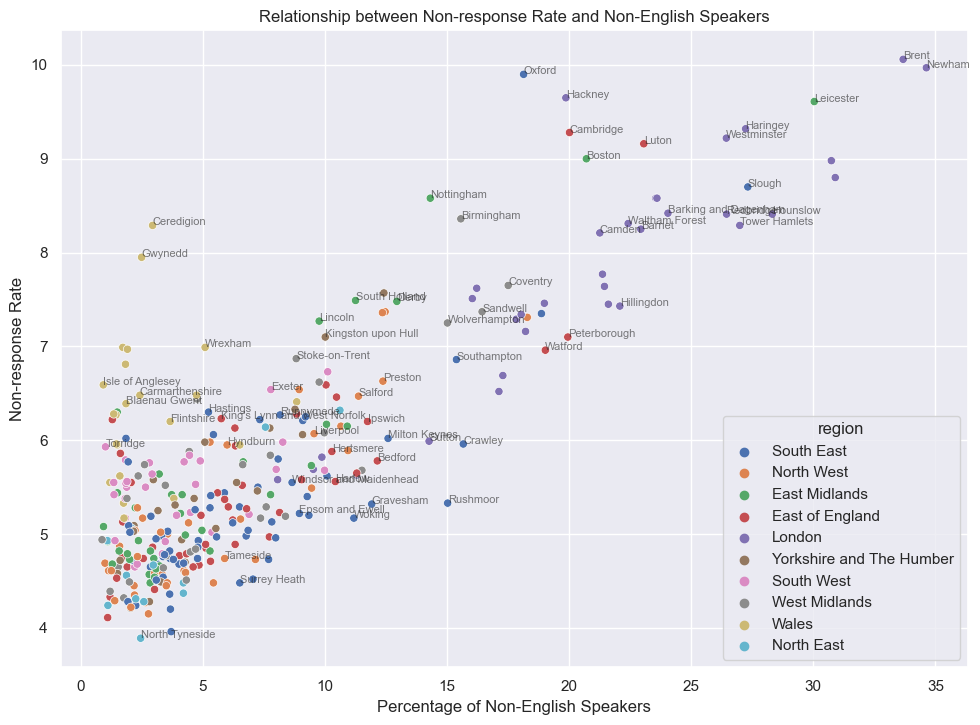

In [26]:
import seaborn as sns

# Set the size of the seaborn plot

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Now we can visualise the relationship between GI NR and % of Non-Eng speakers
# Setting our hue to region, colours each dp by its corresponding region

ax = sns.scatterplot(data=merged_df, x='Non_Eng_Percentages', y='NR_rate', hue='region')

# We can use a bit of Machine Learning to selectively apply LA labels

from sklearn.neighbors import NearestNeighbors

# Find nearest neighbors

X = merged_df[['Non_Eng_Percentages', 'NR_rate']].values
nbrs = NearestNeighbors(n_neighbors=2).fit(X)
distances, indices = nbrs.kneighbors(X)
min_distance = 0.3

for i, row in merged_df.iterrows():
    if distances[i][1] >= min_distance:
        ax.annotate(row['LA_name'], (row['Non_Eng_Percentages'], row['NR_rate']), fontsize=8, alpha=0.6)

# Set x,y, and title labels

plt.xlabel('Percentage of Non-English Speakers')
plt.ylabel('Non-response Rate')
plt.title('Relationship between Non-response Rate and Non-English Speakers')

# Display output

plt.show()


## Urban-rural

As we did with region, we will classify each Local Authority by its urban-rural classification, and add this info as an additional column to our merged_df.

### Read-in data

In [27]:
# Read-in data from urban vs rural

rural = pd.read_excel('../Data/Rural_Urban_2011.xlsx')

In [28]:
# Hmm.. there's a lot of junk here that we don't need

rural.head()

,LAD11CD,LAD18CD,LAD18NM,Total Rural population 2011,Urban City and Town population 2011,Urban Minor Conurbation population 2011,Urban Major Conurbation population 2011,Total Urban population 2011,Total population 2011,Hub towns (rural related) population included in Urban population 2011,Rural including hub towns (rural & rural related) population 2011,Rural including hub towns (rural & rural related) population as % of Total population 2011,RUC11CD,RUC11,Broad RUC11
0,E06000001,E06000001,Hartlepool,3173,88855,0,0,88855,92028,0,3173,3.44,4,Urban with City and Town,Predominantly Urban
1,E06000002,E06000002,Middlesbrough,957,137455,0,0,137455,138412,0,957,0.69,4,Urban with City and Town,Predominantly Urban
2,E06000003,E06000003,Redcar and Cleveland,43880,91297,0,0,91297,135177,0,43880,32.46,3,Urban with Significant Rural (rural including ...,Urban with Significant Rural
3,E06000004,E06000004,Stockton-on-Tees,7536,184074,0,0,184074,191610,0,7536,3.93,4,Urban with City and Town,Predominantly Urban
4,E06000005,E06000005,Darlington,13201,92363,0,0,92363,105564,0,13201,12.50,4,Urban with City and Town,Predominantly Urban


### Cleaning dataset

In [29]:
# Let's get rid of unnecessary columns

rural = rural[['LAD18NM', 'Broad RUC11']]

# And rename them for clarity 

rural = rural.rename(columns = {"LAD18NM": "LA_name", "Broad RUC11": "Urb_Rur"})

In [30]:
# Sort LA_name by alphabetical order and reset the index

rural = rural.sort_values(by = 'LA_name').reset_index(drop = True)

In [31]:
rural

,LA_name,Urb_Rur
0,Adur,Predominantly Urban
1,Allerdale,Predominantly Rural
2,Amber Valley,Predominantly Urban
3,Arun,Predominantly Urban
4,Ashfield,Predominantly Urban
...,...,...
321,Wychavon,Predominantly Rural
322,Wycombe,Urban with Significant Rural
323,Wyre,Predominantly Rural
324,Wyre Forest,Urban with Significant Rural


### Merge datasets

In [32]:
# Add this urb_rur info to our merged_df

merged_df = merged_df.merge(rural, on=['LA_name'], how='left')

In [33]:
merged_df.head()

,LA_name,Observation,Non_Eng_Percentages,NR_rate,region,Urb_Rur
0,Adur,1971,3.14,4.68,South East,Predominantly Urban
1,Allerdale,1073,1.15,4.61,North West,Predominantly Rural
2,Amber Valley,1850,1.51,5.44,East Midlands,Predominantly Urban
3,Arun,9469,5.89,5.44,South East,Predominantly Urban
4,Ashfield,3944,3.22,5.64,East Midlands,Predominantly Urban


In [34]:
# Check for missing values in Urb_Rur

merged_df.Urb_Rur.isna().sum()

30

In [35]:
# Let's locate them

missing = merged_df[merged_df.Urb_Rur.isna()]

missing.region.value_counts()

Wales              22
South West          3
East of England     2
East Midlands       2
South East          1
Name: region, dtype: int64

In [36]:
# Ah! Some missing values, mostly for our Welsh LA's

# Let's fill them in

# Create boolean mask to ID where region column == Wales
mask = merged_df['region'] == 'Wales'

# Locate rows, then in the urb_rur column, enter the below value
merged_df.loc[mask, 'Urb_Rur'] = 'Welsh/not specified'


In [37]:
# We will also fill in our other missing LAs more generally...

mask2 = merged_df['Urb_Rur'].isna()
merged_df.loc[mask2, 'Urb_Rur'] = 'Not specified'

In [38]:
# Check it worked...

merged_df.Urb_Rur.value_counts()

Predominantly Urban             174
Predominantly Rural              80
Urban with Significant Rural     47
Welsh/not specified              22
Not specified                     8
Name: Urb_Rur, dtype: int64

In [39]:
merged_df.Urb_Rur.isna().sum()

0

## Bokeh trial visualisation

In [40]:
# Let's see if we can make a standalone Bokeh plot for some of this data

from bokeh.models.annotations import LabelSet
from bokeh.models import ColumnDataSource, Label, LabelSet
from bokeh.palettes import Category10
from bokeh.io import show
from bokeh.models import CheckboxGroup, CustomJS
from bokeh.layouts import column
from bokeh.models import Button
from bokeh.plotting import figure, curdoc

# Bokeh has a hover tool, allowing you to scroll over dps to reveal info
# To configure the tool, we must set our tooltips arguments...

# We simply define a list of tuples which refer to column values in our merged_df 

tool = [
    ("index", "$index"),
    ("(x,y)", "(@Non_Eng_Percentages, @NR_rate)"),
    ("name","@LA_name"),
]

# Create graph figure, set title and x and y labels

p1 = figure(title="Relationship between NR rate and Non-English Speakers", x_axis_label="Percentage of Non-English Speakers", y_axis_label= "Non-response rate", tooltips = tool)

# To colour each data point by region we first loop over each unique region and its colour
for region, color in zip(merged_df.region.unique(), Category10[10]):
#     Subset dataframe by region for each unique region
    b = merged_df[merged_df.region == region]
#     Each dp within that region is then plotted with its data and specific colour
    p1.circle(x = 'Non_Eng_Percentages', y = 'NR_rate', size = 10, alpha = 0.5, color = color, legend_label = region, muted_color = color, muted_alpha = 0.1, source = b)


# Set location of legend

p1.legend.location = "bottom_right"

# Make it so that when a specific legend is clicked, its dps are removed from plot
p1.legend.click_policy="hide"

# Set legend title 
p1.legend.title = "Regions"

# Display output
output_notebook()
show(p1)


Loading BokehJS ...

# Outputs

In [42]:
merged_df.to_csv('../Data/lang_rural_region_gi.csv', index = False)

# This will save us from having to calculate Non-English percentages in our SO dataset!
non_eng_sum.to_csv('../Data/non_eng_sum.csv', index = False)